## Introduction

* **Natural Language Processing (NLP):** The discipline of computer science, artificial intelligence and linguistics that is concerned with the creation of computational models that process and understand natural language. These include: making the computer understand the semantic grouping of words (e.g. cat and dog are semantically more similar than cat and spoon), text to speech, language translation and many more

* **Sentiment Analysis:** It is the interpretation and classification of emotions (positive, negative and neutral) within text data using text analysis techniques. Sentiment analysis allows organizations to identify public sentiment towards certain words or topics.

In this notebook, we'll develop a **Sentiment Analysis model** to categorize a tweet as **Positive or Negative.**


## Table of Contents
1. [Importing dependencies](#p1)
2. [Importing dataset](#p2)
s. [Exploratory Data Analysis](#p11)
3. [Preprocessing Text](#p3)
4. [Analysing data](#p4)
5. [Splitting data](#p5)
6. [TF-IDF Vectoriser](#p6)
7. [Transforming Dataset](#p7)
8. [Creating and Evaluating Models](#p8)
    * [BernoulliNB Model](#p8-1)
    * [LinearSVC Model](#p8-2)
    * [Logistic Regression Model](#p8-3)
9. [Saving the Models](#p9)
10. [Using the Model](#p10)

## <a name="p1">Importing Dependencies</a>

In [1]:
# utilities
import re
import pickle
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Natural Language Toolkit (nltk)
from nltk.stem import WordNetLemmatizer
from nltk import download
download('stopwords')
download('wordnet')
from nltk.corpus import stopwords

# Model Buildig (sklearn)
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

#Data Splitting and Traininig
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## <a name="p2">Importing dataset</a>
The dataset being used is the **sentiment140 dataset**. It contains 1,600,000 tweets extracted using the **Twitter API**. The tweets have been annotated **(0 = Negative, 4 = Positive)** and they can be used to detect sentiment.
 
*[The training data isn't perfectly categorised as it has been created by tagging the text according to the emoji present. So, any model built using this dataset may have lower than expected accuracy, since the dataset isn't perfectly categorised.]*

**It contains the following 6 fields:**
1. **sentiment**: the polarity of the tweet *(0 = negative, 4 = positive)*
2. **ids**: The id of the tweet *(2087)*
3. **date**: the date of the tweet *(Sat May 16 23:58:44 UTC 2009)*
4. **flag**: The query (lyx). If there is no query, then this value is NO_QUERY.
5. **user**: the user that tweeted *(robotickilldozr)*
6. **text**: the text of the tweet *(Lyx is cool)*

We require only the **sentiment** and **text** fields, so we discard the rest.

Furthermore, we're changing the **sentiment** field so that it has new values to reflect the sentiment. **(0 = Negative, 1 = Positive)**

In [2]:
# Getting the data from kaggle
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv


In [3]:
encoding_used = "ISO-8859-1"
tweets_df = pd.read_csv("/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv", encoding = encoding_used)
tweets_df.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [4]:
data_columns  = ["target", "ids", "date", "flag", "user", "text"]
encoding_used = "ISO-8859-1"

tweets_df = pd.read_csv("/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv", encoding = encoding_used, names = data_columns )
tweets_df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


## <a name="p11">Exploratory Data Analysis</a>

In [5]:
target_group = tweets_df.groupby('target').count()['text']
target_group

target
0    800000
4    800000
Name: text, dtype: int64

[Text(0, 0, 'Negative'), Text(1, 0, 'Positive')]

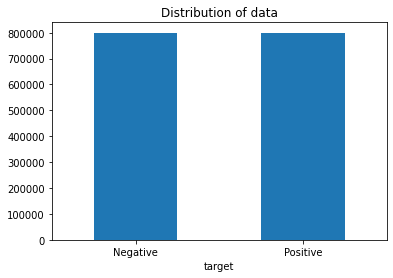

In [6]:
# Plotting the distribution for dataset.
ax = target_group.plot(kind='bar', title='Distribution of data', legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation = 0)

* **target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)**
* **This means we only have negative and positive labels.**
* **I will change all positive labels to 1 i.e all 4 == 1**

## <a > Keeping only relevant values </a>

In [7]:
tweets_df.columns

Index(['target', 'ids', 'date', 'flag', 'user', 'text'], dtype='object')

In [8]:
data = tweets_df[['target', 'text']]
data.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


## Renaming Column

In [9]:
data.columns = ["sentiment", "text"]
data.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


## Replacing value

In [10]:
data[data['sentiment'] != 0].head()

,sentiment,text
800000,4,I LOVE @Health4UandPets u guys r the best!!
800001,4,im meeting up with one of my besties tonight! ...
800002,4,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800003,4,Being sick can be really cheap when it hurts t...
800004,4,@LovesBrooklyn2 he has that effect on everyone


In [11]:
data['sentiment'] = data['sentiment'].replace(4,1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [12]:
#Confirming 4 == 1
data[data['sentiment'] != 0].head()

,sentiment,text
800000,1,I LOVE @Health4UandPets u guys r the best!!
800001,1,im meeting up with one of my besties tonight! ...
800002,1,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800003,1,Being sick can be really cheap when it hurts t...
800004,1,@LovesBrooklyn2 he has that effect on everyone


## Converting data to a list data structure

In [13]:
text, sentiment = list(data['text']), list(data['sentiment'])

## Checking Output of Data Structure

In [14]:
text[0:16]

["@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D",
 "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!",
 '@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds',
 'my whole body feels itchy and like its on fire ',
 "@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. ",
 '@Kwesidei not the whole crew ',
 'Need a hug ',
 "@LOLTrish hey  long time no see! Yes.. Rains a bit ,only a bit  LOL , I'm fine thanks , how's you ?",
 "@Tatiana_K nope they didn't have it ",
 '@twittera que me muera ? ',
 "spring break in plain city... it's snowing ",
 'I just re-pierced my ears ',
 "@caregiving I couldn't bear to watch it.  And I thought the UA loss was embarrassing . . . . .",
 '@octolinz16 It it counts, idk why I did either. you never talk to me anymore ',
 "@smarrison i wo

In [15]:
sentiment[0:16]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

## <a name="p3">Preprocess Text</a>
**Text Preprocessing** is traditionally an important step for **Natural Language Processing (NLP)** tasks. It transforms text into a more digestible form so that machine learning algorithms can perform better.

**The Preprocessing steps taken are:**
1. **Lower Casing:** Each text is converted to lowercase. #Helps to keep things normalized
2. **Replacing URLs:** Links starting with **"http" or "https" or "www"** are replaced by **"URL"**.
3. **Replacing Emojis:** Replace emojis by using a pre-defined dictionary containing emojis along with their meaning. *(eg: ":)" to "EMOJIsmile")*
4. **Replacing Usernames:** Replace @Usernames with word **"USER"**. *(eg: "@Kaggle" to "USER")*
5. **Removing Non-Alphabets:** Replacing characters except Digits and Alphabets with a space.
6. **Removing Consecutive letters:** 3 or more consecutive letters are replaced by 2 letters. *(eg: "Heyyyy" to "Heyy")*
7. **Removing Short Words:** Words with length less than 2 are removed.
8. **Removing Stopwords:** Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. *(eg: "the", "he", "have")*
9. **Lemmatizing:** Lemmatization is the process of converting a word to its base form. *(e.g: “Great” to “Good”)*

## Defining Emojis and their meanings

In [16]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining Stop words in English

In [17]:
mystopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [18]:
english_stop_words =  stopwords.words('english')
english_stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [19]:
stopwordlist = stopwords.words('english') + mystopwordlist

## Preprocesing Function

In [20]:
def preprocess(textdata):
    processedText = []
    
    #creating a Lemmatizer
    wordLemma = WordNetLemmatizer() #define the imported library
    
    # Defining regular expression pattern we can find. in tweets
    
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)" # e.g check out https://dot.com for more
    userPattern       = '@[^\s]+' # e.g @FagbamigbeK check this out
    alphaPattern      = "[^a-zA-Z0-9]" # e.g I am *10 better!
    sequencePattern   = r"(.)\1\1+"  # e.g Heyyyyyyy, I am back!
    seqReplacePattern = r"\1\1" # e.g Replace Heyyyyyyy with Heyy
    
    
    for tweet in textdata:
        tweet = tweet.lower() #normalizing all text to a lower case
        
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet) #using the substitution method of the regular expression library
        
        
        # Replace all emojis.
        for emoji in emojis.keys(): #in each of the looped tweet, replace each emojis with their respective meaning
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])  # emojis[emoji] helps to get the value of the emoji from the dictionary
            
            
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)  #To hide Personal Information, we can replace all usernames with User
        
        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet) # e.g I am *10 better!
        
        
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet) # e.g Replace Heyyyyyyy with Heyy
        
        
        tweetwords = ''
        for word in tweet.split():
            if len(word) > 2 and word.isalpha():
                word = wordLemma.lemmatize(word)
                tweetwords += (word + ' ')
        
        processedText.append(tweetwords)
        
    return processedText

## Noting the time text preprocessing took

In [21]:
import time
t = time.time()
preprocessedtext = preprocess(text) #the preprocess function at work
print(f'Text Processing Done.')
print(f'Time taken for text processing: {round(time.time()-t)} seconds')

Text Processing Done.
Time taken for text processing: 133 seconds


## <a name="p4">Analysing the data</a>
Now we're going to analyse the preprocessed data to get an understanding of it. We'll plot **Word Clouds** for **Positive and Negative** tweets from our dataset and see which words occur the most.

## Before Processing

In [22]:
text[0:11]

["@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D",
 "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!",
 '@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds',
 'my whole body feels itchy and like its on fire ',
 "@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. ",
 '@Kwesidei not the whole crew ',
 'Need a hug ',
 "@LOLTrish hey  long time no see! Yes.. Rains a bit ,only a bit  LOL , I'm fine thanks , how's you ?",
 "@Tatiana_K nope they didn't have it ",
 '@twittera que me muera ? ',
 "spring break in plain city... it's snowing "]

## After Processing

In [23]:
preprocessedtext[0:11]

['USER URL aww that bummer you shoulda got david carr third day EMOJIwink ',
 'upset that can update his facebook texting and might cry result school today also blah ',
 'USER dived many time for the ball managed save the rest out bound ',
 'whole body feel itchy and like it fire ',
 'USER not behaving all mad why here because can see you all over there ',
 'USER not the whole crew ',
 'need hug ',
 'USER hey long time see yes rain bit only bit lol fine thanks how you ',
 'USER nope they didn have ',
 'USER que muera ',
 'spring break plain city snowing ']

In [24]:
negative_sentiments = preprocessedtext[:800000]
negative_sentiments[0:10]

['USER URL aww that bummer you shoulda got david carr third day EMOJIwink ',
 'upset that can update his facebook texting and might cry result school today also blah ',
 'USER dived many time for the ball managed save the rest out bound ',
 'whole body feel itchy and like it fire ',
 'USER not behaving all mad why here because can see you all over there ',
 'USER not the whole crew ',
 'need hug ',
 'USER hey long time see yes rain bit only bit lol fine thanks how you ',
 'USER nope they didn have ',
 'USER que muera ']

In [25]:
data_neg = []
for words in negative_sentiments:
    words = words.lower().replace("user","")
    words = words.lower().replace("url","")
    data_neg.append(words)
    
data_neg[0:10]

['  aww that bummer you shoulda got david carr third day emojiwink ',
 'upset that can update his facebook texting and might cry result school today also blah ',
 ' dived many time for the ball managed save the rest out bound ',
 'whole body feel itchy and like it fire ',
 ' not behaving all mad why here because can see you all over there ',
 ' not the whole crew ',
 'need hug ',
 ' hey long time see yes rain bit only bit lol fine thanks how you ',
 ' nope they didn have ',
 ' que muera ']

In [26]:
word_cloud = WordCloud(max_words = 1000 , width = 1600 , height = 800, collocations=False)

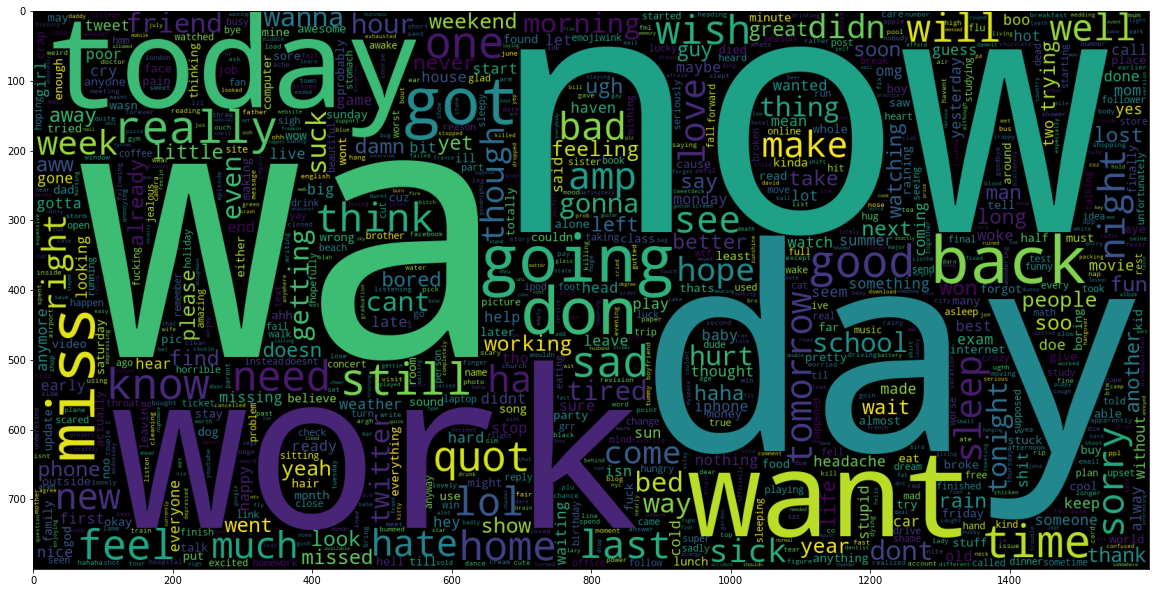

In [27]:
plt.figure(figsize = (20,20))
negative_wc = word_cloud.generate(" ".join(data_neg))
plt.imshow(negative_wc)

### Word-Cloud for Positive tweets.

In [28]:
positive_sentiments = preprocessedtext[800000:]
positive_sentiments[0:10]

['love USER guy the best ',
 'meeting with one besties tonight cant wait girl talk ',
 'USER thanks for the twitter add sunisa got meet you once hin show here the area and you were sweetheart ',
 'being sick can really cheap when hurt too much eat real food plus your friend make you soup ',
 'USER ha that effect everyone ',
 'USER you can tell him that just burst out laughing really loud because that thanks for making come out sulk ',
 'USER thans for your response ihad already find this answer ',
 'USER jealous hope you had great time vega how did you like the acm love your show ',
 'USER congrats fletcher for finally joining twitter ',
 'USER responded stupid cat helping type forgive error ']

In [29]:
data_pos = []
for words in positive_sentiments:
    words = words.lower().replace("user","")
    words = words.lower().replace("url","")
    data_pos.append(words)
    
data_pos[0:10]

['love  guy the best ',
 'meeting with one besties tonight cant wait girl talk ',
 ' thanks for the twitter add sunisa got meet you once hin show here the area and you were sweetheart ',
 'being sick can really cheap when hurt too much eat real food plus your friend make you soup ',
 ' ha that effect everyone ',
 ' you can tell him that just burst out laughing really loud because that thanks for making come out sulk ',
 ' thans for your response ihad already find this answer ',
 ' jealous hope you had great time vega how did you like the acm love your show ',
 ' congrats fletcher for finally joining twitter ',
 ' responded stupid cat helping type forgive error ']

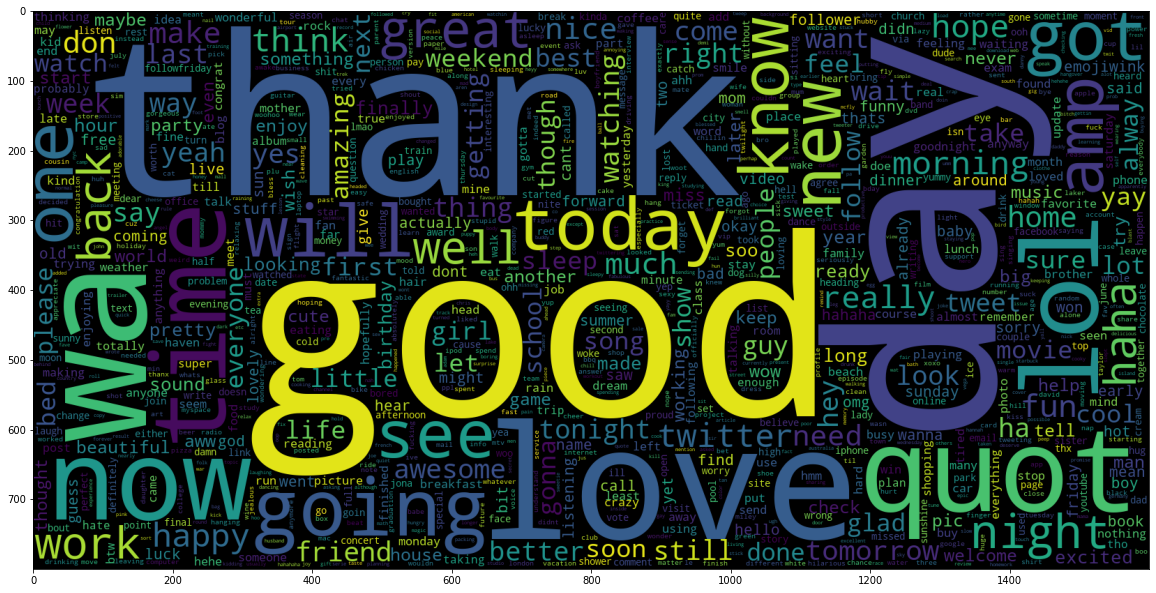

In [30]:
plt.figure(figsize = (20,20))
positive_wc = word_cloud.generate(" ".join(data_pos))
plt.imshow(positive_wc)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(preprocessedtext, sentiment,
                                                    test_size = 0.05, random_state = 0)
print(f'Data Split done.')

Data Split done.


## <a name="p6">TF-IDF Vectoriser</a>
**TF-IDF indicates what the importance of the word is in order to understand the document or dataset.** Let us understand with an example. Suppose you have a dataset where students write an essay on the topic, My House. In this dataset, the word a appears many times; it’s a high frequency word compared to other words in the dataset. The dataset contains other words like home, house, rooms and so on that appear less often, so their frequency are lower and they carry more information compared to the word. This is the intuition behind TF-IDF.

**TF-IDF Vectoriser** converts a collection of raw documents to a **matrix of TF-IDF features**. The **Vectoriser** is usually trained on only the **X_train** dataset. 

**ngram_range**  is the range of number of words in a sequence. *[e.g "very expensive" is a 2-gram that is considered as an extra feature separately from "very" and "expensive" when you have a n-gram range of (1,2)]*

**max_features** specifies the number of features to consider. *[Ordered by feature frequency across the corpus]*.